In [1]:
%gui wx
import sys
import os


notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ





import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()


loadFSL()


import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


import requests
import urllib.request
from tqdm import tqdm


from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
from fsl.wrappers import mcflirt



import glob
import pandas as pd
import numpy as np
import json
import subprocess

Gtk-Message: 14:24:55.635: Failed to load module "canberra-gtk-module"


In [2]:
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

In [3]:
bids_root='data_mp1'
dataset_id = 'ds000171'
subject = '01'

deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

In [ ]:
#subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, "--target-dir", bids_root, "--include", 'sub-control{}'.format(subject)], check=True)

In [4]:
fsleyesDisplay = FSLeyesServer()

14:25:06: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:25:06: Debug: Adding duplicate animation handler for '1' type
14:25:06: Debug: Adding duplicate animation handler for '2' type
14:25:06: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:25:06: Debug: Adding duplicate animation handler for '1' type
14:25:06: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:2743): Gtk-CRITICAL **: 14:25:06.861: gtk_window_resize: assertion 'height > 0' failed


In [10]:
from nilearn.image import concat_imgs

# Define the paths to your gzipped NIfTI files
file_paths = [
    'sub-control01_task-music_run-1_bold.nii.gz',
    'sub-control01_task-music_run-2_bold.nii.gz',
    'sub-control01_task-music_run-3_bold.nii.gz'

]

def standardize(img):
    data = img.get_fdata()
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / std
    return nib.Nifti1Image(standardized_data, img.affine)

# Initialize a list to hold standardized data
standardized_data_list = []

# Process each file
for file_path in file_paths:
    img = nib.load(os.path.join(bids_root, 'sub-control01', 'func', file_path))
    
    standardized_data = standardize(img)
    standardized_data_list.append(standardized_data)


concatenated_img = concat_imgs(standardized_data_list)


# Save the concatenated image as a gzipped NIfTI file
nib.save(concatenated_img, os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold.nii.gz'))

In [5]:
#mkdir_no_exist(bids_root)
mkdir_no_exist(deriv_root)
mkdir_no_exist(preproc_root)
mkdir_no_exist(os.path.join(preproc_root, 'sub-control01'))
mkdir_no_exist(os.path.join(preproc_root, 'sub-control01', 'func'))

path_original_data = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as data_mp1/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293]

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [ ]:
fsleyesDisplay.show()
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

In [6]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.003267,0.002930,5.552720e-07,-0.059817,-0.518985,-0.470659
1,-0.003333,0.002930,-1.600820e-04,-0.066681,-0.490942,-0.467984
2,-0.003147,0.002880,-1.880300e-04,-0.053630,-0.470922,-0.446214
3,-0.003264,0.003291,-3.337180e-04,-0.067658,-0.483699,-0.463707
4,-0.002729,0.003120,-3.183150e-04,-0.073350,-0.470581,-0.494909
...,...,...,...,...,...,...
310,0.008946,-0.000008,-2.131270e-03,-0.087116,0.400872,0.237711
311,0.009100,-0.000159,-2.114960e-03,-0.084539,0.374362,0.217879
312,0.009154,-0.000425,-1.901570e-03,-0.085075,0.404540,0.224777
313,0.008975,-0.000425,-2.162820e-03,-0.103438,0.370850,0.211481


In [7]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

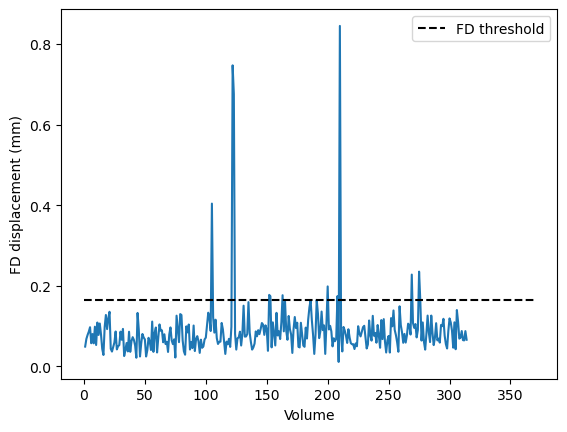

In [8]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
#%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [ ]:
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.nii.gz')

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

In [ ]:

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path + '_smoothed-6mm')

In [ ]:

func_path = op.join(bids_root, 'sub-control01', 'func')



evt1=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
evt2=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
evt3=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-3_events.tsv'), sep='\t')


evt_concat=pd.concat([evt1,evt2,evt3], ignore_index=True)
evt_concat

In [ ]:
import numpy as np

# Set parameters
TR = 3  # Repetition time (in seconds)
total_time = 309  # Total time of the scan in seconds
time_points = np.arange(0, total_time, TR)


In [ ]:
from nilearn.glm.first_level import make_first_level_design_matrix

# Generate design matrix using Nilearn's HRF
design_matrix = make_first_level_design_matrix(
    frame_times=time_points,
    events=evt_concat,
    hrf_model='spm',
    drift_model='polynomial'
)

In [ ]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)
plt.show()

In [ ]:
fmri_img = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.nii.gz')

In [ ]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, events)